# TP 5 Réseaux de neurones - Multi classification et Propagation en arrière
Dans ce TP, nous aimerions entrainer un réseau de neurones pour la tâche de classification en utilisant l'algorithme d propagation en arrière (backpropagation).

L'ensemble de données que nous allons utiliser est le même que celui utilisé durant le TP1, i.e. les images de chiffres manuscrits.


# Importation des librairies necessaires au travail

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random

# Lecture des fichiers de données
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [3]:
# données
data = np.genfromtxt('data.csv', delimiter=',', dtype=float)
data.shape

(5000, 401)

Dans ces données (data), les 400 premières colonnes representent les pixels de l'image (20x20), la dernière colonne represente la classe de l'image (chiffres de 0 à 9). (http://yann.lecun.com/exdb/mnist/)

Chaque ligne represente un exemple de notre ensemble de données. 

Mettons ces données dans leus vecteurs correspondants.

In [4]:
# rajoutons l'ordonnée à l'origine theta 0
intercept=np.ones((data.shape[0],1))
X=np.column_stack((intercept,data[:,:-1]))
y=data[:,-1]
# forcer y à avoir une seule colonne
y = y.reshape( y.shape[0], 1)

In [5]:
print('X', X.shape ,' y ', y.shape)

X (5000, 401)  y  (5000, 1)


Visualisation aléatoire de quelques données

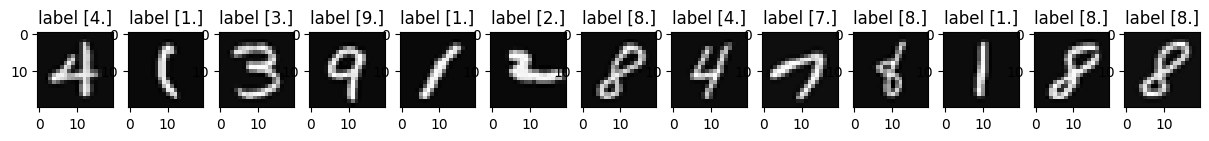

In [6]:
plt.figure(figsize=(15,8))
for i in range(13):
    c = random.randint(X.shape[0])
    a = X[c,1:].reshape((20, 20))
    a=np.transpose(a)
    plt.subplot(1,13,i+1)
    plt.title('label '+ str(y[c]))
    plt.imshow(a,cmap='gray')

Transformer y de tel sorte à avoir un vecteur pour chaque exemple

Equivalent de tocategorical

In [10]:
YY=np.zeros((y.shape[0], int(np.max(y))+1))
YY.shape # YY will become a one-hot encoded version of y — often used as target labels for classification tasks in neural networks or ML models that expect categorical inputs in that format.
YY[0]
YY[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [12]:
for i in range (YY.shape[0]):
    YY[i,int(y[i])]=1
YY

C:\Users\moous\AppData\Local\Temp\ipykernel_7448\1370419558.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  YY[i,int(y[i])]=1


array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

# Réseaux de neurones
Pour cette partie, nous choisissons une réseau simple:

- une couche d'entrée avec 400 noeuds (20 x 20 pixels) + le biais
- une couche cachée avec 25 noeuds
- une couche de sortie avec 10 noeuds (nombre de classes)

In [13]:
# weight matrix of the first layer
W1 = np.genfromtxt('W1.csv', delimiter=',', dtype=float)
W1.shape


(25, 401)

In [14]:
# weight matrix of the second layer
W2 = np.genfromtxt('W2.csv', delimiter=',', dtype=float)
W2.shape

(10, 26)

In [15]:
input_layer_size  = 400
hidden_layer_size = 25   
num_labels = 10

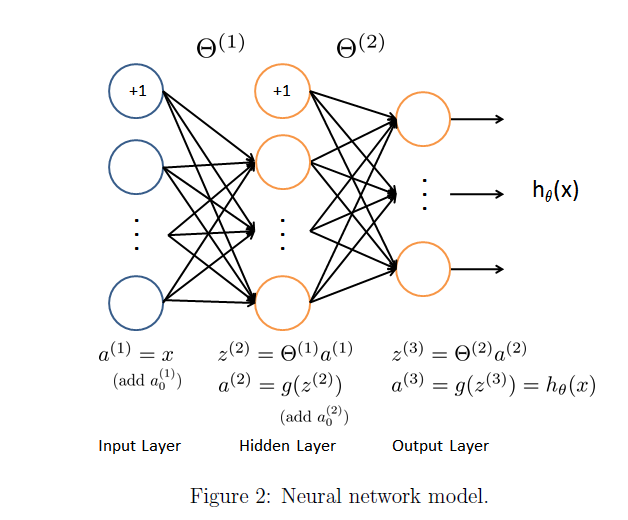

# Calcul du coût

# TODO  1 calcul du coût
**Tâche 1**: Modifier la fonction computeCost afin d'obtenir un coût avec régularisation

Rappelons que le coût avec régularisation est calculé comme suit:

$ J(\theta)= \frac{1}{m} \sum_{i=1}^m\sum_{k=1}^K \left[ -y_k^{(i)} \log (h_\theta(x^{(i)}) )_k - (1-y_k^{(i)}) \log (1-h_\theta(x^{(i)}) )_k \right] + \frac{\lambda}{2m} \left[ \sum_{j=1}^{25}\sum_{k=1}^{400} \left( \theta_{j,k}^{(1)} \right)^2 +   \sum_{j=1}^{10}\sum_{k=1}^{25} \left( \theta_{j,k}^{(2)} \right)^2 \right] $

In [23]:
def sigmoid(z):
    # pour une valeur donnée, cette fonction calculera sa sigmoid
    return 1/(1+np.exp(-z))

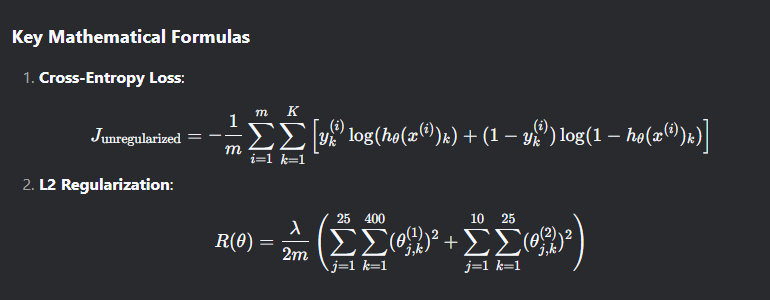

In [24]:
# theta 1 is the weight matrix between the input layer and the hidden layer
# theta 2 is the weight matrix between the hidden layer and the output layer.
def computeCost(X, YY, theta1, theta2, hidden_layer_size, lambda_):
    # Forward propagation
    a1 = X
    
    # Layer 2 calculations
    intercept = np.ones((X.shape[0], 1))
    z2 = np.column_stack((intercept, np.matmul(a1, np.transpose(theta1)))) # Add bias unit to z2 (Weighted sum before activation)
    a2 = sigmoid(z2) 
    a2[:, 0] = 1  # Set bias unit to 1
    
    # Output layer calculations
    z3 = np.matmul(a2, np.transpose(theta2))
    a3 = sigmoid(z3) # a3 contains probabilities for each class
    
    # Calculate unregularized cost
    m = YY.shape[0] # number of training examples
    J = (1/m) * np.sum(np.sum((-YY * np.log(a3)) - ((1 - YY) * np.log(1 - a3))))
    
    # Regularization term (excluding bias terms)
    # For theta1 (ignore first column which is for bias) because we don't want to regularize the bias term --> it could force it towards zero
    reg_theta1 = np.sum(np.sum(theta1[:, 1:]**2))
    
    # For theta2 (ignore first column which is for bias)
    reg_theta2 = np.sum(np.sum(theta2[:, 1:]**2))
    
    # Add regularization to cost
    regularization = (lambda_/(2*m)) * (reg_theta1 + reg_theta2)
    J += regularization
    
    return J

# TODO  2 calcul du gradient
**Tâche 2**: Implémenter la fonction NNCostFunction afin de retourner:

- Le coût avec régularisation
- Le gardient du coût par rapport à chaqu'un des paramètres du réseau

Rappelons le gradient de la sigmoid:

$ sigmoid(z) =\sigma(z)= \frac{1}{1-e^{-z}}$

$ \sigma(z)^\prime = \sigma(z)(1-\sigma(z)) =a(1-a)$ tel que $a$ est l'activation d'une couche donnée

L'algorithme à implementer est comme suit:

Pour chaque exemple de l'ensemble d'apprentissage faire

Pour chaque noeud de la couche de sortie, calculer la dérivée (gradient):

$\delta_k^{(3)} = \left( a_k^{(3)}- y_k \right)  $

Pour chaque noeud de la couche caché calculer la dérivée (gradient):

$\delta^{(2)} =  \left(\Theta^{(2)}\right)^T \delta^{(3)} \quad .* \quad \sigma^\prime\left(z^{(2)} \right) $

Notons que l'opérateur $.*$ represente la multiplication élement par élement et non pas la multiplication matricielle

Le gradient de chaque noeud et de chaque couche sera finalement:

$\Delta^{(l)} =  \Delta^{(l)} + \delta^{(l)} * \left( a^{(l)} \right)^T $

Fin pour

Fin pour

Diviser le gradient cumulé par le nombre d'exemples:

$ \frac{\partial J(\Theta)} { \partial \Theta_{i,j)}^{(l)}} = \frac{1}{m} \Delta_{(i,j)}^{(l)}$


In [25]:
def sigmoid_gradient(z):
    s = sigmoid(z)
    return s * (1 - s)

In [22]:
def sigmoid(z):
    """Sigmoid activation function"""
    return 1 / (1 + np.exp(-z))

In [ ]:
def NNCostFunction(X, YY, theta1, theta2, hidden_layer_size, lambda_):
    """
    Compute cost and gradient for 2-layer neural network with regularization
    
    Parameters:
    X - input data (m x n)
    YY - one-hot encoded labels (m x num_classes)
    theta1 - weights input to hidden layer (hidden_layer_size x n+1)
    theta2 - weights hidden to output layer (num_classes x hidden_layer_size+1)
    hidden_layer_size - number of hidden units
    lambda_ - regularization parameter
    
    Returns:
    J - regularized cost
    theta1_grad - gradient for theta1
    theta2_grad - gradient for theta2
    """
    m = YY.shape[0]  # Number of training examples
    num_classes = YY.shape[1]
    
    # Initialize gradients
    theta1_grad = np.zeros(theta1.shape)
    theta2_grad = np.zeros(theta2.shape)
    
    # Forward propagation
    a1 = np.hstack([np.ones((m, 1)), X])  # Add bias unit (m x n+1) --> horizontal stack of ones and X
    
    z2 = a1 @ theta1.T  # unactivated hidden layer values (m x hidden_layer_size)
    a2 = sigmoid(z2) # apply sigmoid element wise : enables neural networks to learn complex patterns
    a2 = np.hstack([np.ones((m, 1)), a2])  # Add bias unit (m x hidden_layer_size+1) Allows the network to learn a bias term for the next layer
    
    z3 = a2 @ theta2.T  # (m x num_classes) 
    a3 = sigmoid(z3)
    
    # Calculate cost
    J = (-1/m) * np.sum(YY * np.log(a3) + (1-YY) * np.log(1-a3))
    
    # Add regularization (excluding bias terms)
    reg_term = (lambda_/(2*m)) * (np.sum(theta1[:, 1:]**2) + np.sum(theta2[:, 1:]**2))
    J += reg_term
    
    # Backpropagation
    delta3 = a3 - YY  # Output layer error (m x num_classes) : difference between predicted and actual labels
    
    # Hidden layer error (excluding bias)
    delta2 = (delta3 @ theta2[:, 1:]) * sigmoid_gradient(z2)  # (m x hidden_layer_size), sigmoid_gradient(z2) computes the derivative 
    # of the sigmoid function (Scales by how sensitive each neuron was)
    # delta 2 contains the error for each hidden unit, scaled by the derivative of the activation function
    
    # Accumulate gradients
    theta1_grad = (delta2.T @ a1) / m  # (hidden_layer_size x n+1) : averages how much each hidden neuron activation (a2) contributed to output error
    theta2_grad = (delta3.T @ a2) / m  # (num_classes x hidden_layer_size+1)
    
    # Add regularization terms (skip bias terms)
    theta1_grad[:, 1:] += (lambda_/m) * theta1[:, 1:]
    theta2_grad[:, 1:] += (lambda_/m) * theta2[:, 1:]
    
    return J, theta1_grad, theta2_grad




# TODO  3 entrainement du réseau
**Tâche 3**: Entrainer le réseau en utilisant la descente du gradient:
Ici il faudra reprendre l'algorithme de la descente du gradient afin de mettre à jour les paramètres du réseau


In [ ]:
def gradientDescent(X, y, Theta, alpha, iterations):
    
   return best_theta1, best_theta2, costs

In [ ]:
iterations = 800
lambda_ = 1.0
alpha = 0.8
theta1 = W1
theta2 = W2
#appel descente du gradient non régularisé et affichage de la courbe du cout

# TODO 4 : Régularisation
Mettre à jour le calcul du coût en ajoutant le terme de régularisation et comparer les résultats (avec et sans régularisation)

In [ ]:
iterations = 800
lambda_ = 1.0
alpha = 0.8
theta1 = W1
theta2 = W2
#appel descente du gradient régularisé et affichage de la courbe du cout

# TODO 5 : Prédiction

Appliquer une propagation en avant en utilisant les paramètres données pour prédir les classes de l'ensemble d'apprentissage.



In [ ]:
def predict (W1, W2, X):
    
    # appliquer une propagation en avant
    # !--- n'oubliez pas d'appliquer la sigmoid à chaque couche afin d'avoir les probabilités ---!
    
    # prédire la classe en choisissant la probabilité maximale parmi les 10 noeuds de sortie
    return y_pred

In [ ]:
# calcul de precision = nombre de valeurs bien prédites (ici sur toute la base X)
y_pred=predict(X)
precision = np.mean(y==y_pred)*100
precision

# Vérification de l'implementation
Comparer vos algorithmes à ceux de scikitlearn

# Optionnel : Renforcement de l'apprentissage
Mettre ici toute idée qui pourrait renforcer votre apprentissage